In [21]:
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

In [3]:
DATASET_PATH = "/Users/przemyslawniedziela/.cache/kagglehub/datasets/arhamrumi/amazon-product-reviews/versions/1/Reviews.csv"

CONTRACTIONS = {
    "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
    "'t": " not", "'ve": " have", "'m": " am"
}

### Initial Exploration 

In [4]:
dataset = pd.read_csv(DATASET_PATH, index_col = [0])

In [5]:
dataset.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 568454 entries, 1 to 568454
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   ProfileName             568428 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   Summary                 568427 non-null  object
 8   Text                    568454 non-null  object
dtypes: int64(4), object(5)
memory usage: 43.4+ MB


In [7]:
dataset.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


In [8]:
print(f"""Nr of records: {dataset.shape[0]}
Nr of distinct products: {dataset['ProductId'].unique().shape[0]}
Nr of distinct users: {dataset['ProfileName'].unique().shape[0]}""")

Nr of records: 568454
Nr of distinct products: 74258
Nr of distinct users: 218416


### Pre-processing 

In [9]:
dataset = dataset.dropna() 

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def expand_contractions(text):
    """Expand common contractions in text."""
    for contraction, expanded in CONTRACTIONS.items():
        text = re.sub(contraction, expanded, text)
    return text

def preprocess_text(text):
    """
    Preprocess the input text by cleaning, normalizing, and tokenizing.

    - Convert text to lowercase.
    - Expand contractions
    - Remove punctuation and special characters.
    - Remove numbers.
    - Remove stopwords.
    - Lemmatize the tokens to their base forms.
    """
    text = expand_contractions(text.lower())
    text = re.sub(r'[^a-z\s]', '', text)  
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]    
    return ' '.join(tokens)

dataset['clean_text'] = dataset['Text'].apply(preprocess_text)

### Calculating embeddings

In [15]:
model = SentenceTransformer('all-MiniLM-L6-v2')

batch_size = 1024  
review_embeddings = []

for start in range(0, len(dataset), batch_size):
    print(f"Progress: {round(start/dataset.shape[0] * 100, 2)}%")
    batch = dataset['clean_text'].iloc[start:start + batch_size].tolist()
    batch_embeddings = model.encode(batch, show_progress_bar=True)
    review_embeddings.extend(batch_embeddings)

review_embeddings = np.array(review_embeddings)


Progress: 0.0%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


Progress: 0.18%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


Progress: 0.36%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 0.54%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


Progress: 0.72%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


Progress: 0.9%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Progress: 1.08%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Progress: 1.26%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


Progress: 1.44%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s]


Progress: 1.62%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 1.8%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 1.98%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


Progress: 2.16%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Progress: 2.34%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.58it/s]


Progress: 2.52%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 2.7%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Progress: 2.88%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Progress: 3.06%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


Progress: 3.24%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


Progress: 3.42%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Progress: 3.6%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


Progress: 3.78%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Progress: 3.96%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


Progress: 4.14%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 4.32%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Progress: 4.5%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


Progress: 4.68%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Progress: 4.86%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 5.04%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


Progress: 5.22%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Progress: 5.4%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]


Progress: 5.58%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


Progress: 5.76%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Progress: 5.95%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Progress: 6.13%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


Progress: 6.31%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Progress: 6.49%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 6.67%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Progress: 6.85%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


Progress: 7.03%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Progress: 7.21%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Progress: 7.39%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


Progress: 7.57%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Progress: 7.75%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Progress: 7.93%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Progress: 8.11%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 8.29%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


Progress: 8.47%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Progress: 8.65%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 8.83%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Progress: 9.01%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 9.19%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Progress: 9.37%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 9.55%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 9.73%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Progress: 9.91%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


Progress: 10.09%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Progress: 10.27%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Progress: 10.45%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Progress: 10.63%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Progress: 10.81%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


Progress: 10.99%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Progress: 11.17%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


Progress: 11.35%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Progress: 11.53%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Progress: 11.71%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Progress: 11.89%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


Progress: 12.07%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


Progress: 12.25%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Progress: 12.43%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Progress: 12.61%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Progress: 12.79%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Progress: 12.97%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Progress: 13.15%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


Progress: 13.33%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 13.51%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.20it/s]


Progress: 13.69%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 13.87%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


Progress: 14.05%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


Progress: 14.23%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Progress: 14.41%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Progress: 14.59%


Batches: 100%|██████████| 32/32 [00:52<00:00,  1.63s/it]


Progress: 14.77%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Progress: 14.95%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 15.13%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


Progress: 15.31%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Progress: 15.49%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 15.67%


Batches: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Progress: 15.85%


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.15it/s]


Progress: 16.03%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]


Progress: 16.21%


Batches: 100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


Progress: 16.39%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.60it/s]


Progress: 16.57%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Progress: 16.75%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Progress: 16.93%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Progress: 17.11%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


Progress: 17.29%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


Progress: 17.47%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 17.66%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Progress: 17.84%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Progress: 18.02%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]


Progress: 18.2%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Progress: 18.38%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 18.56%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


Progress: 18.74%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Progress: 18.92%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.89it/s]


Progress: 19.1%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Progress: 19.28%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 19.46%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Progress: 19.64%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Progress: 19.82%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


Progress: 20.0%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Progress: 20.18%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Progress: 20.36%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Progress: 20.54%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.56it/s]


Progress: 20.72%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


Progress: 20.9%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 21.08%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


Progress: 21.26%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


Progress: 21.44%


Batches: 100%|██████████| 32/32 [00:08<00:00,  4.00it/s]


Progress: 21.62%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Progress: 21.8%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


Progress: 21.98%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Progress: 22.16%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Progress: 22.34%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]


Progress: 22.52%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Progress: 22.7%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


Progress: 22.88%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 23.06%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Progress: 23.24%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Progress: 23.42%


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.19it/s]


Progress: 23.6%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 23.78%


Batches: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Progress: 23.96%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Progress: 24.14%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


Progress: 24.32%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Progress: 24.5%


Batches: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Progress: 24.68%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Progress: 24.86%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


Progress: 25.04%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 25.22%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 25.4%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


Progress: 25.58%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


Progress: 25.76%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 25.94%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Progress: 26.12%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


Progress: 26.3%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 26.48%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Progress: 26.66%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 26.84%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Progress: 27.02%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Progress: 27.2%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 27.38%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Progress: 27.56%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Progress: 27.74%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


Progress: 27.92%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Progress: 28.1%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Progress: 28.28%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Progress: 28.46%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Progress: 28.64%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Progress: 28.82%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 29.0%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s]


Progress: 29.19%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


Progress: 29.37%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Progress: 29.55%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


Progress: 29.73%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Progress: 29.91%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


Progress: 30.09%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Progress: 30.27%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Progress: 30.45%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Progress: 30.63%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Progress: 30.81%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Progress: 30.99%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 31.17%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.66it/s]


Progress: 31.35%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Progress: 31.53%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 31.71%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


Progress: 31.89%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 32.07%


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.12it/s]


Progress: 32.25%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Progress: 32.43%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.53it/s]


Progress: 32.61%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Progress: 32.79%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Progress: 32.97%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 33.15%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.82it/s]


Progress: 33.33%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 33.51%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 33.69%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Progress: 33.87%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Progress: 34.05%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


Progress: 34.23%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]


Progress: 34.41%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Progress: 34.59%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 34.77%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


Progress: 34.95%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Progress: 35.13%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 35.31%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Progress: 35.49%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Progress: 35.67%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Progress: 35.85%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Progress: 36.03%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


Progress: 36.21%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


Progress: 36.39%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Progress: 36.57%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Progress: 36.75%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 36.93%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 37.11%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Progress: 37.29%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Progress: 37.47%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Progress: 37.65%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Progress: 37.83%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 38.01%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 38.19%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Progress: 38.37%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


Progress: 38.55%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Progress: 38.73%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


Progress: 38.91%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Progress: 39.09%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Progress: 39.27%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Progress: 39.45%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 39.63%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Progress: 39.81%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Progress: 39.99%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Progress: 40.17%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Progress: 40.35%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.52it/s]


Progress: 40.53%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 40.71%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Progress: 40.9%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


Progress: 41.08%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 41.26%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 41.44%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


Progress: 41.62%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 41.8%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s]


Progress: 41.98%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 42.16%


Batches: 100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Progress: 42.34%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Progress: 42.52%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


Progress: 42.7%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 42.88%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 43.06%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 43.24%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 43.42%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Progress: 43.6%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 43.78%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Progress: 43.96%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 44.14%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


Progress: 44.32%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 44.5%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Progress: 44.68%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


Progress: 44.86%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


Progress: 45.04%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 45.22%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.28it/s]


Progress: 45.4%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Progress: 45.58%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Progress: 45.76%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Progress: 45.94%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Progress: 46.12%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 46.3%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Progress: 46.48%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 46.66%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Progress: 46.84%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Progress: 47.02%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Progress: 47.2%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


Progress: 47.38%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 47.56%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Progress: 47.74%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 47.92%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Progress: 48.1%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Progress: 48.28%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.86it/s]


Progress: 48.46%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.90it/s]


Progress: 48.64%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 48.82%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


Progress: 49.0%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 49.18%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Progress: 49.36%


Batches: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it]


Progress: 49.54%


Batches: 100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


Progress: 49.72%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Progress: 49.9%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


Progress: 50.08%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


Progress: 50.26%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s]


Progress: 50.44%


Batches: 100%|██████████| 32/32 [08:21<00:00, 15.67s/it]  


Progress: 50.62%


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


Progress: 50.8%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Progress: 50.98%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 51.16%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Progress: 51.34%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Progress: 51.52%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 51.7%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


Progress: 51.88%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Progress: 52.06%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


Progress: 52.24%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 52.42%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Progress: 52.61%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 52.79%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Progress: 52.97%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Progress: 53.15%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


Progress: 53.33%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Progress: 53.51%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.20it/s]


Progress: 53.69%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


Progress: 53.87%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Progress: 54.05%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 54.23%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 54.41%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Progress: 54.59%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.32it/s]


Progress: 54.77%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Progress: 54.95%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Progress: 55.13%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.39it/s]


Progress: 55.31%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.62it/s]


Progress: 55.49%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Progress: 55.67%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


Progress: 55.85%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 56.03%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Progress: 56.21%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Progress: 56.39%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


Progress: 56.57%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Progress: 56.75%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Progress: 56.93%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Progress: 57.11%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Progress: 57.29%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 57.47%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Progress: 57.65%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 57.83%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


Progress: 58.01%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


Progress: 58.19%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.84it/s]


Progress: 58.37%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Progress: 58.55%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Progress: 58.73%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


Progress: 58.91%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 59.09%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Progress: 59.27%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


Progress: 59.45%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]


Progress: 59.63%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Progress: 59.81%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


Progress: 59.99%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


Progress: 60.17%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Progress: 60.35%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Progress: 60.53%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Progress: 60.71%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Progress: 60.89%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Progress: 61.07%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


Progress: 61.25%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


Progress: 61.43%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Progress: 61.61%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


Progress: 61.79%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Progress: 61.97%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Progress: 62.15%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Progress: 62.33%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 62.51%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.98it/s]


Progress: 62.69%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Progress: 62.87%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 63.05%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Progress: 63.23%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Progress: 63.41%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Progress: 63.59%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


Progress: 63.77%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 63.95%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.97it/s]


Progress: 64.14%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


Progress: 64.32%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Progress: 64.5%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


Progress: 64.68%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


Progress: 64.86%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s]


Progress: 65.04%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


Progress: 65.22%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 65.4%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 65.58%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Progress: 65.76%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Progress: 65.94%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Progress: 66.12%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


Progress: 66.3%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Progress: 66.48%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.57it/s]


Progress: 66.66%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.63it/s]


Progress: 66.84%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


Progress: 67.02%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


Progress: 67.2%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


Progress: 67.38%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 67.56%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


Progress: 67.74%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


Progress: 67.92%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


Progress: 68.1%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.81it/s]


Progress: 68.28%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s]


Progress: 68.46%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Progress: 68.64%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Progress: 68.82%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Progress: 69.0%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Progress: 69.18%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Progress: 69.36%


Batches: 100%|██████████| 32/32 [01:02<00:00,  1.96s/it]


Progress: 69.54%


Batches: 100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


Progress: 69.72%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


Progress: 69.9%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.76it/s]


Progress: 70.08%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


Progress: 70.26%


Batches: 100%|██████████| 32/32 [00:57<00:00,  1.79s/it]


Progress: 70.44%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.26it/s]


Progress: 70.62%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]


Progress: 70.8%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 70.98%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Progress: 71.16%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


Progress: 71.34%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Progress: 71.52%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Progress: 71.7%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


Progress: 71.88%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.02it/s]


Progress: 72.06%


Batches: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


Progress: 72.24%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.93it/s]


Progress: 72.42%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.85it/s]


Progress: 72.6%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Progress: 72.78%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Progress: 72.96%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


Progress: 73.14%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Progress: 73.32%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]


Progress: 73.5%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s]


Progress: 73.68%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


Progress: 73.86%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


Progress: 74.04%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 74.22%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Progress: 74.4%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


Progress: 74.58%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.55it/s]


Progress: 74.76%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Progress: 74.94%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


Progress: 75.12%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


Progress: 75.3%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 75.48%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Progress: 75.66%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


Progress: 75.85%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Progress: 76.03%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]


Progress: 76.21%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.54it/s]


Progress: 76.39%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]


Progress: 76.57%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 76.75%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


Progress: 76.93%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Progress: 77.11%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Progress: 77.29%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


Progress: 77.47%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


Progress: 77.65%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Progress: 77.83%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Progress: 78.01%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


Progress: 78.19%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.01it/s]


Progress: 78.37%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Progress: 78.55%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.98it/s]


Progress: 78.73%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


Progress: 78.91%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Progress: 79.09%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 79.27%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.57it/s]


Progress: 79.45%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


Progress: 79.63%


Batches: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s]


Progress: 79.81%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Progress: 79.99%


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.13it/s]


Progress: 80.17%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 80.35%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Progress: 80.53%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


Progress: 80.71%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s]


Progress: 80.89%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Progress: 81.07%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s]


Progress: 81.25%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Progress: 81.43%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


Progress: 81.61%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


Progress: 81.79%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s]


Progress: 81.97%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.18it/s]


Progress: 82.15%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 82.33%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Progress: 82.51%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Progress: 82.69%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


Progress: 82.87%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Progress: 83.05%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.56it/s]


Progress: 83.23%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s]


Progress: 83.41%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Progress: 83.59%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Progress: 83.77%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Progress: 83.95%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 84.13%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Progress: 84.31%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 84.49%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 84.67%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Progress: 84.85%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


Progress: 85.03%


Batches: 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


Progress: 85.21%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 85.39%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.83it/s]


Progress: 85.57%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 85.75%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Progress: 85.93%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


Progress: 86.11%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Progress: 86.29%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 86.47%


Batches: 100%|██████████| 32/32 [00:10<00:00,  3.14it/s]


Progress: 86.65%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


Progress: 86.83%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Progress: 87.01%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Progress: 87.19%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Progress: 87.37%


Batches: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


Progress: 87.56%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.03it/s]


Progress: 87.74%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]


Progress: 87.92%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


Progress: 88.1%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Progress: 88.28%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.35it/s]


Progress: 88.46%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s]


Progress: 88.64%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


Progress: 88.82%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.96it/s]


Progress: 89.0%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.88it/s]


Progress: 89.18%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]


Progress: 89.36%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Progress: 89.54%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s]


Progress: 89.72%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


Progress: 89.9%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Progress: 90.08%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


Progress: 90.26%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


Progress: 90.44%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 90.62%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Progress: 90.8%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s]


Progress: 90.98%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s]


Progress: 91.16%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 91.34%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s]


Progress: 91.52%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s]


Progress: 91.7%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Progress: 91.88%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]


Progress: 92.06%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


Progress: 92.24%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


Progress: 92.42%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.95it/s]


Progress: 92.6%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 92.78%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.92it/s]


Progress: 92.96%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Progress: 93.14%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Progress: 93.32%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.61it/s]


Progress: 93.5%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


Progress: 93.68%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s]


Progress: 93.86%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Progress: 94.04%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]


Progress: 94.22%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]


Progress: 94.4%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Progress: 94.58%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.59it/s]


Progress: 94.76%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]


Progress: 94.94%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]


Progress: 95.12%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.57it/s]


Progress: 95.3%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.04it/s]


Progress: 95.48%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


Progress: 95.66%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


Progress: 95.84%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.77it/s]


Progress: 96.02%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]


Progress: 96.2%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 96.38%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Progress: 96.56%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Progress: 96.74%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s]


Progress: 96.92%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


Progress: 97.1%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Progress: 97.28%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]


Progress: 97.46%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Progress: 97.64%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


Progress: 97.82%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


Progress: 98.0%


Batches: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


Progress: 98.18%


Batches: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s]


Progress: 98.36%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s]


Progress: 98.54%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s]


Progress: 98.72%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s]


Progress: 98.9%


Batches: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s]


Progress: 99.08%


Batches: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s]


Progress: 99.27%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s]


Progress: 99.45%


Batches: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]


Progress: 99.63%


Batches: 100%|██████████| 32/32 [00:57<00:00,  1.80s/it]


Progress: 99.81%


Batches: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


Progress: 99.99%


Batches: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


### PCA

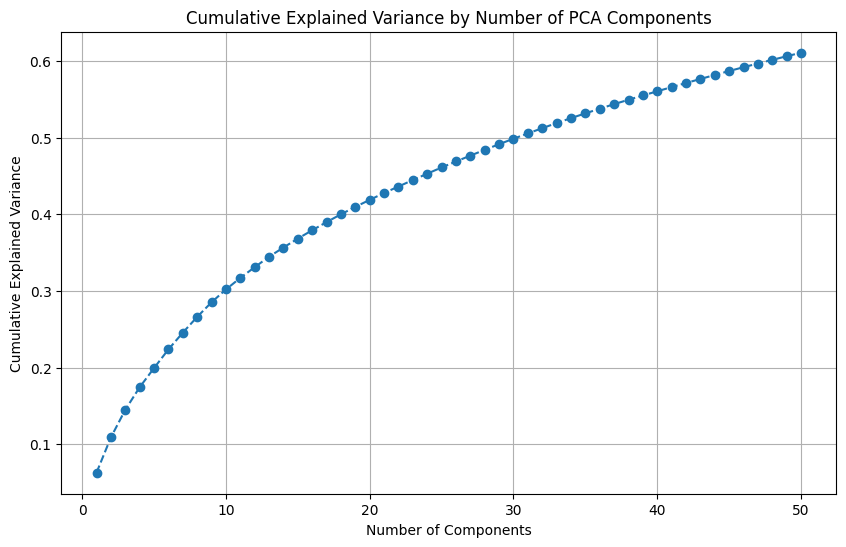

Explained variance by top components: [0.06264993 0.10872394 0.14477108 0.17423187 0.19928353 0.22363879
 0.24549325 0.26609802 0.28522202 0.30193895]


In [18]:
def perform_pca(embeddings, n_components=50):
    """
    Perform PCA on the embeddings and return the PCA model and transformed embeddings.
    - n_components: Number of PCA components to keep.
    """
    pca = PCA(n_components=n_components)
    pca_embeddings = pca.fit_transform(embeddings)
    
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), explained_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    print(f"Explained variance by top components: {explained_variance[:10]}")
    
    return pca, pca_embeddings

pca_model, pca_embeddings = perform_pca(review_embeddings, n_components=50)

/var/folders/dq/fgp118jd64571hh4r6gbvh4w0000gn/T/ipykernel_43234/3980532660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


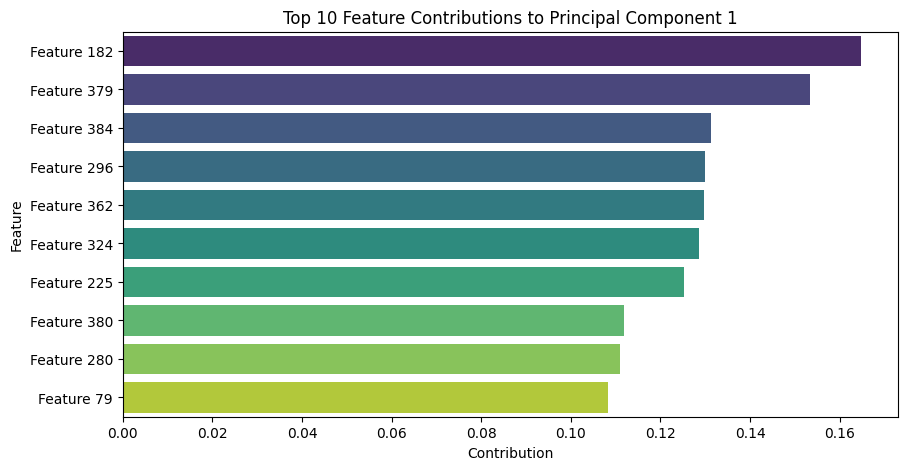

/var/folders/dq/fgp118jd64571hh4r6gbvh4w0000gn/T/ipykernel_43234/3980532660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


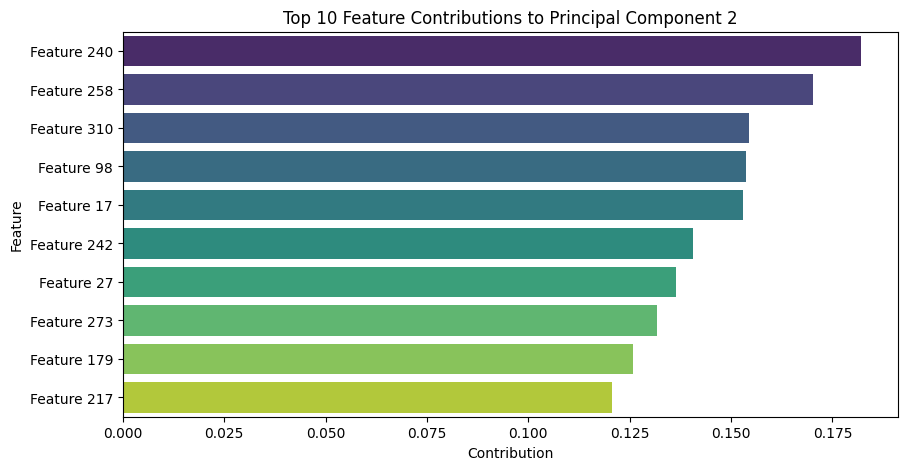

/var/folders/dq/fgp118jd64571hh4r6gbvh4w0000gn/T/ipykernel_43234/3980532660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


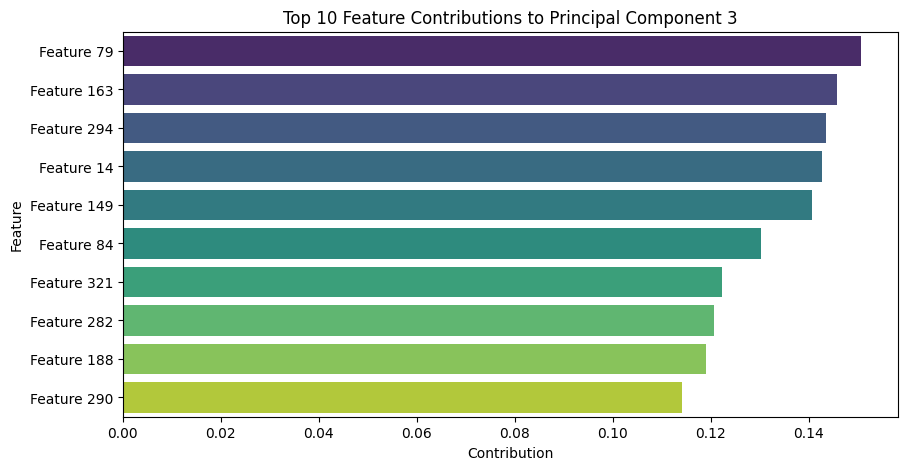

/var/folders/dq/fgp118jd64571hh4r6gbvh4w0000gn/T/ipykernel_43234/3980532660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


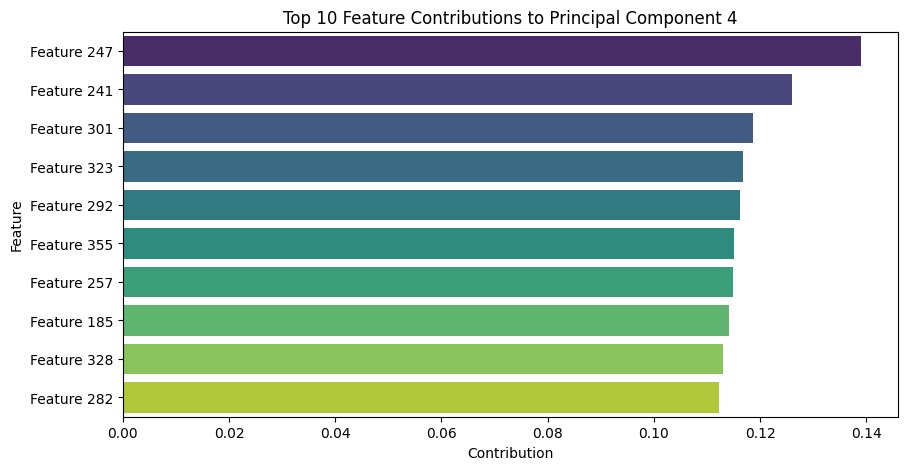

/var/folders/dq/fgp118jd64571hh4r6gbvh4w0000gn/T/ipykernel_43234/3980532660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


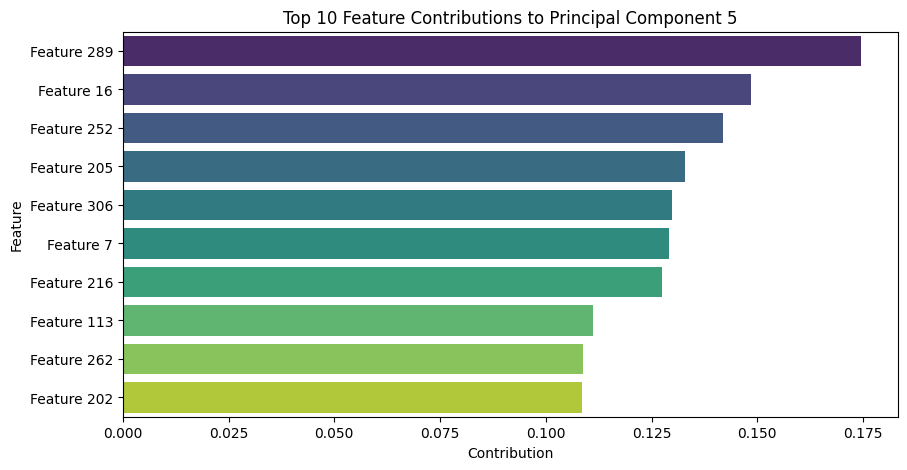

In [22]:
def plot_feature_contributions(pca, feature_names, top_n=10):
    """
    Plot the contributions of original features (words) to each principal component.
    - top_n: Number of top contributing features to display per component.
    """
    component_df = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(len(pca.components_))])

    for i in range(min(5, len(pca.components_))): 
        component = component_df.iloc[i]
        top_features = component.abs().sort_values(ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
        plt.title(f'Top {top_n} Feature Contributions to Principal Component {i+1}')
        plt.xlabel('Contribution')
        plt.ylabel('Feature')
        plt.show()

feature_names = [f'Feature {i+1}' for i in range(review_embeddings.shape[1])]
plot_feature_contributions(pca_model, feature_names, top_n=10)